# K-means Clustering

In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances

# convert scientific notation to decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style('whitegrid')

# Problem definition
Clustering airlines according to average delay, distance, etc.

____________
# Load the Data

### Cleaned, Merged dataset can be downloaded from here: https://www.kaggle.com/arwasheraky/cleaned-flight-delays-2015

In [2]:
df_flights = pd.read_csv('../data/flightsmerged.csv', low_memory=False)
print(df_flights.columns)
df_flights.head()

Index(['MONTH', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'SCHEDULED_DEPARTURE',
       'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'DISTANCE',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED',
       'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY', 'DATE', 'CLASS', 'AIRLINE_CODE', 'AIRLINE_NAME',
       'ORIGIN_AC', 'ORIGIN_NAME', 'ORIGIN_STATE', 'ORIGIN_LATITUDE',
       'ORIGIN_LONGITUDE', 'DESTINATION_AC', 'DESTINATION_NAME', 'DEST_STATE',
       'DEST_LATITUDE', 'DEST_LONGITUDE'],
      dtype='object')


,MONTH,FLIGHT_NUMBER,TAIL_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,...,ORIGIN_AC,ORIGIN_NAME,ORIGIN_STATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_AC,DESTINATION_NAME,DEST_STATE,DEST_LATITUDE,DEST_LONGITUDE
0,1,98,N407AS,00:05:00,23:54:00,-11.00,205.00,1448,04:30:00,04:08:00,...,ANC,Ted Stevens Anchorage International Airport,AK,61.17,-150.00,SEA,Seattle-Tacoma International Airport,WA,47.45,-122.31
1,1,2336,N3KUAA,00:10:00,00:02:00,-8.00,280.00,2330,07:50:00,07:41:00,...,LAX,Los Angeles International Airport,CA,33.94,-118.41,PBI,Palm Beach International Airport,FL,26.68,-80.10
2,1,840,N171US,00:20:00,00:18:00,-2.00,286.00,2296,08:06:00,08:11:00,...,SFO,San Francisco International Airport,CA,37.62,-122.37,CLT,Charlotte Douglas International Airport,NC,35.21,-80.94
3,1,258,N3HYAA,00:20:00,00:15:00,-5.00,285.00,2342,08:05:00,07:56:00,...,LAX,Los Angeles International Airport,CA,33.94,-118.41,MIA,Miami International Airport,FL,25.79,-80.29
4,1,135,N527AS,00:25:00,00:24:00,-1.00,235.00,1448,03:20:00,02:59:00,...,SEA,Seattle-Tacoma International Airport,WA,47.45,-122.31,ANC,Ted Stevens Anchorage International Airport,AK,61.17,-150.00


_________________
# Feature Engineering

In [3]:
# Keep just the delayed flights

df = df_flights[df_flights['CLASS'] == 'Delayed']
df = df.drop(columns = ['CANCELLATION_REASON','CANCELLED'])
print("Original dataset : ",df_flights.shape)
print("Now : ",df.shape)

Original dataset :  (5697506, 33)
Now :  (5596829, 31)


## Add a column

In [4]:
# Average delay column

df['AVG_DELAY'] = 0
df['AVG_DELAY'] = (df['DEPARTURE_DELAY'] + df['ARRIVAL_DELAY']) / 2.0
df['AVG_DELAY'].head(10)


0   -16.50
1    -8.50
2     1.50
3    -7.00
4   -11.00
5     1.50
6   -11.50
7     2.00
8   -12.00
9    -6.00
Name: AVG_DELAY, dtype: float64

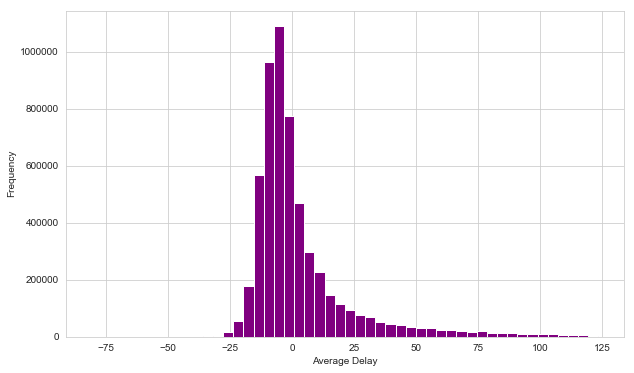

In [5]:
plt.figure(figsize=(10,6))
plt.hist(df['AVG_DELAY'], bins=50, color='purple')
plt.xlabel("Average Delay")
plt.ylabel("Frequency")
plt.show()

In [6]:
df = df.dropna()

## Label Encodeing

In [16]:
# get_dummies

# Convert MONTH to STRING
df['MONTH'] = df['MONTH'].replace(to_replace = list(range(1, 13)),
                                  value=['1','2','3','4','5','6','7','8','9','10','11','12'])

categorical = ['MONTH'] #'DEST_STATE','ORIGIN_STATE'

df_dummies = pd.get_dummies(df[categorical])
df = pd.concat([df, df_dummies], axis=1)

## Change Time to Int

In [17]:
# Convert the time to seconds

def time_to_num (time_str):
    
    if type(time_str) is int:
        return time_str
    
    h,m,s = time_str.split(':')
    result = int(h) * 3600 + int(m) * 60 + int(s)
    return result

In [18]:
# Call the Function:

df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].apply(time_to_num)
df['SCHEDULED_ARRIVAL'] =df['SCHEDULED_ARRIVAL'].apply(time_to_num)

#Print a sample..
df[['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL']].head()

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL
0,300,16200
1,600,28200
2,1200,29160
3,1200,29100
4,1500,12000


## Change Date to Int

In [19]:
from datetime import datetime

def date_to_int(time_str):
    
    if type(time_str) is float:
        return time_str
    
    result = datetime.fromisoformat(time_str).timestamp()
    return result

In [20]:
# Call the Function:

df['DATE'] = df['DATE'].apply(date_to_int)
df['DATE'].head()

0   1420088400.00
1   1420088400.00
2   1420088400.00
3   1420088400.00
4   1420088400.00
Name: DATE, dtype: float64

## Select Model Columns

In [21]:
X_columns = ['DISTANCE','AVG_DELAY', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL','DATE'] + list(df_dummies.columns)

In [23]:
# normalize the columns
df_norm = df.copy()
df_norm = df_norm[X_columns]

for col in X_columns:
    df_norm[col] = df[col].astype(float)
    df_norm[col] = StandardScaler().fit_transform(df_norm[col].values.reshape(-1, 1))

df_norm.head()

,DISTANCE,AVG_DELAY,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DATE,MONTH_1,MONTH_11,MONTH_12,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9
0,1.02,-0.92,-2.75,-2.09,-1.68,3.23,-0.31,-0.31,-0.29,-0.32,-0.32,-0.32,-0.32,-0.33,-0.33,-0.31
1,2.47,-0.55,-2.73,-1.43,-1.68,3.23,-0.31,-0.31,-0.29,-0.32,-0.32,-0.32,-0.32,-0.33,-0.33,-0.31
2,2.41,-0.08,-2.70,-1.38,-1.68,3.23,-0.31,-0.31,-0.29,-0.32,-0.32,-0.32,-0.32,-0.33,-0.33,-0.31
3,2.49,-0.48,-2.70,-1.38,-1.68,3.23,-0.31,-0.31,-0.29,-0.32,-0.32,-0.32,-0.32,-0.33,-0.33,-0.31
4,1.02,-0.66,-2.68,-2.32,-1.68,3.23,-0.31,-0.31,-0.29,-0.32,-0.32,-0.32,-0.32,-0.33,-0.33,-0.31


_______
# Model Training

In [24]:
k = 3
kmeans = KMeans(n_clusters=k).fit(df_norm.values)

print(set(kmeans.labels_))
print(collections.Counter(kmeans.labels_))

{0, 1, 2}
Counter({1: 1948650, 2: 1794511, 0: 1365861})


In [25]:
df_results = df.copy()
df_norm['cluster'] = kmeans.labels_
df_results['cluster'] = kmeans.labels_

____________
# Analyze the Results

[('12', 456474), ('9', 455456), ('11', 453931)]
[('7', 501298), ('8', 492350), ('5', 478248), ('6', 476754)]
[('3', 481119), ('4', 470028), ('1', 446751), ('2', 396613)]
DISTANCE


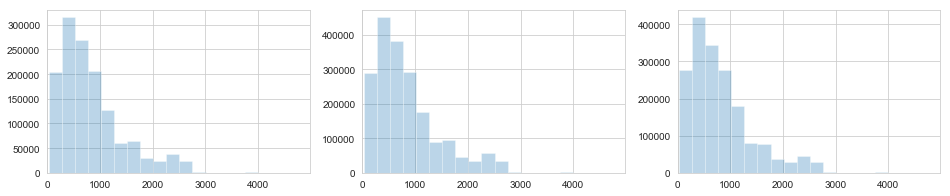

AVG_DELAY


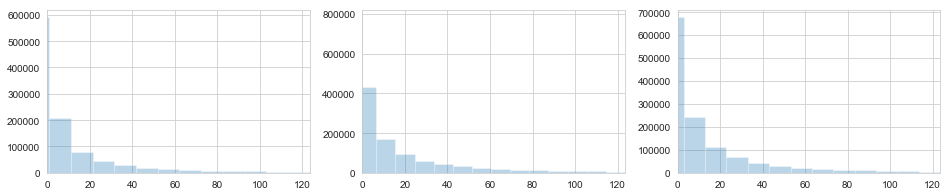

SCHEDULED_DEPARTURE


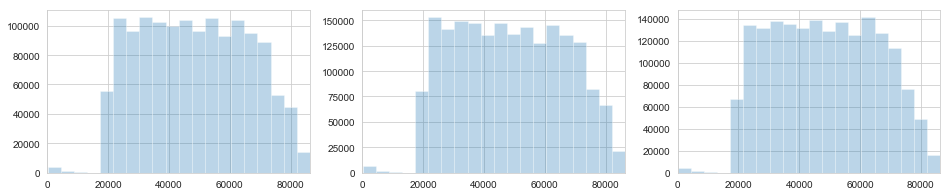

SCHEDULED_ARRIVAL


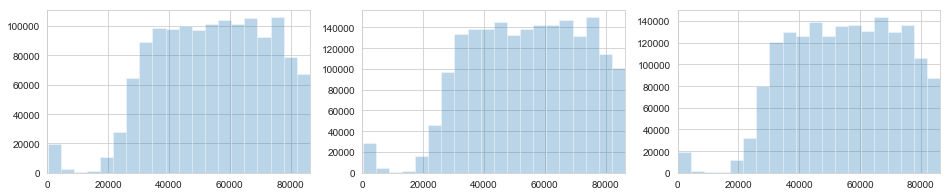

DATE


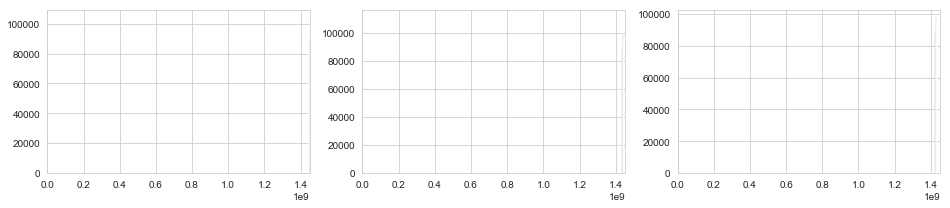

MONTH_1


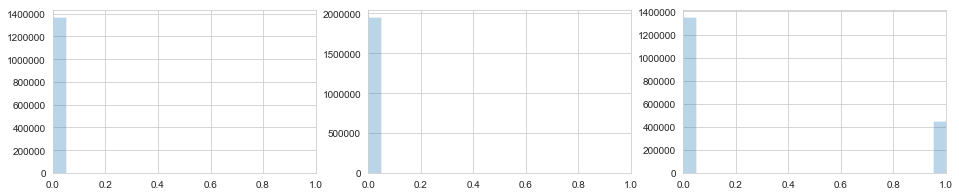

MONTH_11


In [ ]:

df_results = df_results.reset_index()

for cluster in sorted(set(kmeans.labels_)):
    print(collections.Counter(df_results[df_results['cluster']==cluster]['MONTH']).most_common(4))

n_clusters = len(set(kmeans.labels_))

for col in X_columns:
    print(col)
    i = 1
    plt.figure(figsize=(16,3))
    
    for cluster in sorted(set(kmeans.labels_)):
        plt.subplot(1, n_clusters, i)
        plt.xlim([0,df_results[col].max()])
        plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=20)
        i += 1
        
    plt.show()